In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

/Users/pokutnik/anaconda3/envs/ekans/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [46]:
cc = pd.read_csv('./posts_ccompare_raw.csv', index_col=0, encoding='utf-8')
cc['Timestamp'] = pd.to_datetime(cc['Timestamp'])

# Reaction features

In [47]:
features_reactions = pd.DataFrame(index=cc.index)
features_reactions['n_up'] = cc['Actions.Agree.Total']
features_reactions['n_down'] = cc['Actions.Disagree.Total']
features_reactions['n_reply'] = cc['Actions.Comment.Total']

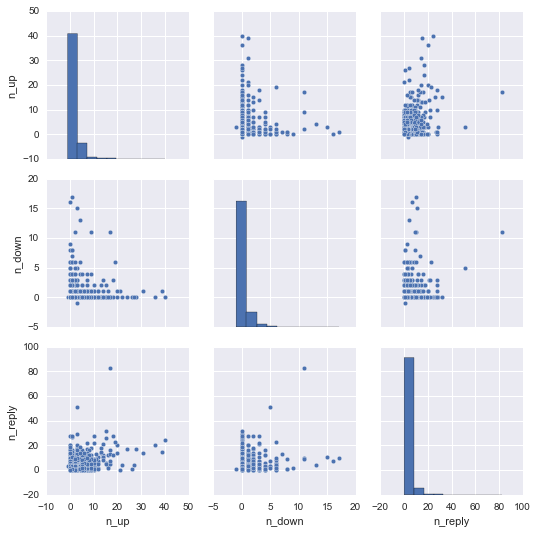

In [48]:
sns.pairplot(features_reactions)

# Post date features

In [49]:
features_date = pd.DataFrame(index=cc.index)
features_date['t_week'] = cc.Timestamp.dt.week
features_date['t_dow'] = cc.Timestamp.dt.dayofweek
features_date['t_hour'] = cc.Timestamp.dt.hour
features_date['t_day'] = cc.Timestamp.dt.day

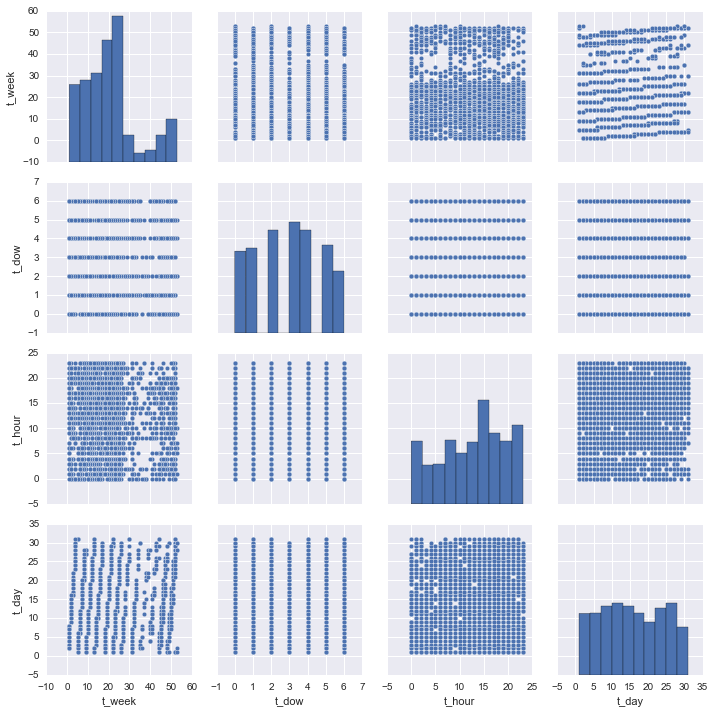

In [50]:
sns.pairplot(features_date)

# Spacy NLP ...

In [51]:
import spacy                           # See "Installing spaCy"
nlp = spacy.load('en')                 # You are here.


In [81]:
spacy_docs = pd.DataFrame(index=cc.index)
docs = cc.Body.apply(nlp)
vec = docs.apply(lambda x: x.vector)
feature_word_vec = pd.DataFrame(vec.tolist(), columns=['spacy_%s'%i for i in range(300)])

In [87]:
feature_word_vec['spacy_sent'] = docs.apply(lambda x: x.sentiment)

In [129]:
# tfidf 

In [132]:
'''
Author: Giovanni Kastanja
Python: 3.6.0
Date: 24/6/2017
'''
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.sparse import csr_matrix
text = cc['Body']
# create a stopset (words that occur to many times)
stopset = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=stopset)
features_tfidf = pd.DataFrame(vectorizer.fit_transform(text).toarray())


# Target

In [7]:
targets = pd.read_csv('./btc-ind.csv')
targets['date'] = pd.to_datetime(targets['Date'])
targets = targets.set_index('date')
del targets['Date']
targets.tail()

,BTC_pd_T0,BTC_rpd_T0,BTC_v_T0,BTC_rpd_T1,BTC_v_T1,BTC_pd_T2,BTC_v_T2,BTC_s_T2,BTC_dh_m3,BTC_dl_m3,...,BTC_log_s_T2,BTC_cbrt_rpd_T0,BTC_cbrt_pd_T1,BTC_cbrt_dv_T1,BTC_cbrt_hl_T1,BTC_cbrt_pd_T2,BTC_cbrt_dh_m3,BTC_cbrt_dl_m3,BTC_cbrt_do_m3,BTC_cbrt_dp_m3
date,,,,,,,,,,,,,,,,,,,,,
2017-06-18,-115.54,-0.043516,92004.22,0.037392,81829.22,99.28,111303.55,3.000340e+08,41.650000,62.363333,...,19.519406,-0.351736,-3.370213,-21.669296,5.054862,4.630422,3.466344,3.965608,4.437038,-2.179750
2017-06-19,77.26,0.030423,81829.22,0.054364,111303.55,138.06,116033.61,3.132347e+08,-43.750000,31.386667,...,19.562463,0.312175,5.989054,30.889768,6.555346,5.168398,-3.523649,3.154388,-4.005548,-3.349197
2017-06-20,137.56,0.052568,111303.55,0.040515,116033.61,106.02,78297.60,2.103188e+08,102.390000,73.530000,...,19.164135,0.374604,3.932190,16.786322,5.753231,4.732921,4.678276,4.189429,-2.718934,2.434569
2017-06-21,-76.76,-0.027868,116033.61,-0.015978,78297.60,-44.01,56938.10,1.553034e+08,63.530000,38.646667,...,18.860891,-0.303182,-3.159516,-33.541720,5.104085,-3.530616,3.990184,3.380939,4.149354,2.317179
2017-06-22,45.22,0.016888,78297.60,-0.041268,56938.10,-110.50,65779.46,1.740187e+08,-30.083333,2.670000,...,18.974673,0.256563,3.199414,-27.745786,5.148732,-4.798669,-3.110107,1.387300,-3.438659,-2.539463


In [8]:
join_by_date = pd.DataFrame(index=cc.index)
join_by_date['date'] = cc.Timestamp.dt.round(freq="d")

In [88]:
Y_all = join_by_date.join(targets, on='date').dropna()
groups = Y_all['date']
del Y_all['date']
cols = Y_all.columns
index = Y_all.index
#Y_all = pd.DataFrame(normalize(Y_all, axis=1, norm='l2'), columns=cols, index=index)
Y_all = Y_all - Y_all.mean()
Y_all = Y_all/Y_all.std()
#Y_all.plot()

# Combine features

In [175]:
#features = pd.concat([features_date, features_tfidf, features_reactions, feature_word_vec], axis=1)
features = pd.concat([features_date, features_reactions, feature_word_vec], axis=1)

In [176]:
X_all = features.ix[Y_all.index]
X_all.shape

(2909, 304)

In [135]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso

In [138]:
rf = RandomForestRegressor(n_estimators=10, max_depth=3, criterion='mse')
xgb = XGBRegressor(n_estimators=10)
regressors = [rf, Lasso()]

In [139]:
target_scores = {}
for indicator in targets.columns:
    Y =Y_all[indicator]    
    for reg in regressors:
        tag = indicator+':'+str(reg)[:15]
        scores = cross_val_score(reg, X_all, Y, cv=4, groups=groups, scoring='neg_mean_squared_error')
        print np.mean(scores), tag
        target_scores[tag] = scores

cv_score = pd.DataFrame(target_scores)

-1.01510250221 BTC_pd_T0:RandomForestReg
-1.00489834393 BTC_pd_T0:Lasso(alpha=1.0
-1.01362175733 BTC_rpd_T0:RandomForestReg
-1.00700271374 BTC_rpd_T0:Lasso(alpha=1.0
-1.12117041142 BTC_v_T0:RandomForestReg
-1.12333273979 BTC_v_T0:Lasso(alpha=1.0
-1.0279897913 BTC_rpd_T1:RandomForestReg
-1.02159575107 BTC_rpd_T1:Lasso(alpha=1.0
-1.14329555947 BTC_v_T1:RandomForestReg
-1.14257585964 BTC_v_T1:Lasso(alpha=1.0
-1.03427313345 BTC_pd_T2:RandomForestReg
-1.02477879379 BTC_pd_T2:Lasso(alpha=1.0
-1.13260911269 BTC_v_T2:RandomForestReg
-1.12544047748 BTC_v_T2:Lasso(alpha=1.0
-1.51004848987 BTC_s_T2:RandomForestReg
-1.50287169074 BTC_s_T2:Lasso(alpha=1.0
-1.01129501027 BTC_dh_m3:RandomForestReg
-1.00167162664 BTC_dh_m3:Lasso(alpha=1.0
-1.00526912285 BTC_dl_m3:RandomForestReg
-1.00073235397 BTC_dl_m3:Lasso(alpha=1.0
-1.00164740181 BTC_do_m3:RandomForestReg
-1.00238122689 BTC_do_m3:Lasso(alpha=1.0
-1.00571974508 BTC_dp_m3:RandomForestReg
-1.00041327712 BTC_dp_m3:Lasso(alpha=1.0
-1.17915445144 BTC_lo

In [140]:
ms = cv_score.mean(axis=0)
ms.sort_values(ascending=False)

BTC_cbrt_dh_m3:RandomForestReg    -0.996806
BTC_dp_m3:Lasso(alpha=1.0         -1.000413
BTC_dl_m3:Lasso(alpha=1.0         -1.000732
BTC_cbrt_dh_m3:Lasso(alpha=1.0    -1.001004
BTC_cbrt_dv_T1:Lasso(alpha=1.0    -1.001270
BTC_do_m3:RandomForestReg         -1.001647
BTC_dh_m3:Lasso(alpha=1.0         -1.001672
BTC_do_m3:Lasso(alpha=1.0         -1.002381
BTC_cbrt_dl_m3:Lasso(alpha=1.0    -1.003605
BTC_cbrt_dp_m3:Lasso(alpha=1.0    -1.003615
BTC_cbrt_do_m3:Lasso(alpha=1.0    -1.003677
BTC_pd_T0:Lasso(alpha=1.0         -1.004898
BTC_cbrt_rpd_T0:Lasso(alpha=1.0   -1.005027
BTC_dl_m3:RandomForestReg         -1.005269
BTC_dp_m3:RandomForestReg         -1.005720
BTC_rpd_T0:Lasso(alpha=1.0        -1.007003
BTC_cbrt_pd_T1:Lasso(alpha=1.0    -1.007573
BTC_cbrt_do_m3:RandomForestReg    -1.008547
BTC_cbrt_dv_T1:RandomForestReg    -1.008752
BTC_cbrt_dl_m3:RandomForestReg    -1.010595
BTC_dh_m3:RandomForestReg         -1.011295
BTC_rpd_T0:RandomForestReg        -1.013622
BTC_pd_T0:RandomForestReg       

In [146]:
indicator = 'BTC_cbrt_dv_T1:Lasso(alpha=1.0'
indicator = indicator.split(":")[0]
Y = Y_all[indicator]
reg = XGBRegressor(n_estimators=100)
reg.fit(X_all, Y)
Y_t = reg.predict(X_all)
error = abs(Y - Y_t)

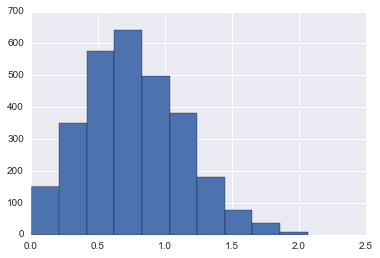

In [147]:
error.hist()

In [148]:
# DROP THE BULL$HIT
itruth = error < error.quantile(0.3)
X = X_all[itruth]
Y = Y_all[indicator][itruth]
G = groups[itruth]

In [149]:
reg = XGBRegressor(n_estimators=100, max_depth=8)
scores = cross_val_score(reg, X, Y, cv=4, groups=G, scoring='neg_mean_squared_error')
print sorted(scores)

[-0.23556982483024885, -0.21678759213304766, -0.18345071771185228, -0.16639456674108286]


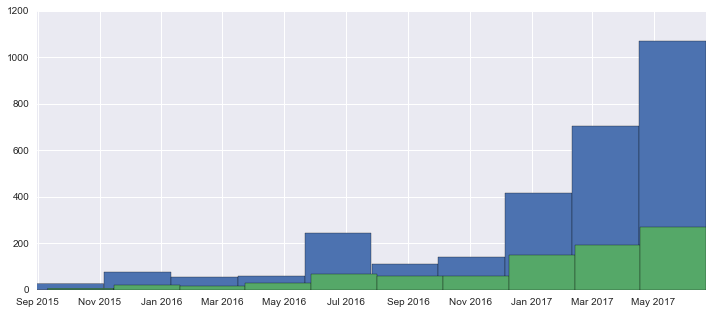

In [150]:
ax = groups.hist(figsize=(12,5))
G.hist(ax=ax)

In [163]:
reg = XGBRegressor(n_estimators=100, max_depth=8)
reg.fit(X,Y)
Y_ = reg.predict(X)
truth_df = pd.DataFrame({'date': G, 'Y': Y_})

date
2017-05-11   -0.207513
2017-05-12   -0.006514
2017-05-13   -0.295262
2017-05-15   -0.207278
2017-05-17   -0.089345
2017-05-19   -0.348372
2017-05-20    0.100844
2017-05-28   -0.578722
2017-05-30   -0.103358
2017-05-31   -0.336672
2017-06-01   -0.411269
2017-06-02   -0.333014
2017-06-03   -0.400911
2017-06-07   -0.377851
2017-06-08   -0.376306
2017-06-10   -0.473987
2017-06-16   -0.434028
2017-06-17   -0.439826
2017-06-18   -0.583273
2017-06-20   -0.664884
2017-06-22   -0.302429
dtype: float32

In [157]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}



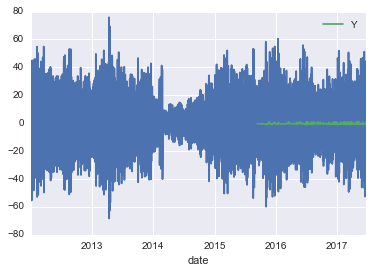

In [160]:
ax = targets.BTC_cbrt_dv_T1.plot()
truth.plot(ax=ax)

In [162]:
truth

,Y
date,
2015-09-11,-0.259642
2015-09-28,-0.383556
2015-10-06,-0.554653
2015-10-07,-0.604275
2015-10-09,-0.145151
2015-11-05,-0.914925
2015-11-07,-0.438083
2015-11-17,-0.642703
2015-11-19,1.160174


In [188]:
def drop_bs(indicator, q=0.3):
    Y = Y_all[indicator]
    reg = XGBRegressor(n_estimators=100)
    reg.fit(X_all, Y)
    Y_t = reg.predict(X_all)
    error = abs(Y - Y_t)
    error.hist()
    itruth = error < error.quantile(q)
    X = X_all[itruth]
    Y = Y_all[indicator][itruth]
    G = groups[itruth]
    reg = XGBRegressor(n_estimators=30, max_depth=5)
    scores = cross_val_score(reg, X, Y, cv=4, groups=G, scoring='neg_mean_squared_error')
    print sorted(scores)
    print "MEAN CV SCORE: ", np.mean(scores)
    
    reg = XGBRegressor(n_estimators=100, max_depth=8)
    reg.fit(X,Y)
    Y_ = reg.predict(X)
    agg = pd.Series(Y_).groupby(G)
    truthscore = agg.mean()
    impact_count = agg.count()
    truth_max = agg.max()
    return pd.DataFrame(dict(truthscore=truthscore, impact_count=impact_count, truth_max=truth_max, date=truthscore.index))

[-0.41367598429198782, -0.3770965620906167, -0.35208172797206533, -0.33427650602529679]
MEAN CV SCORE:  -0.369282695095


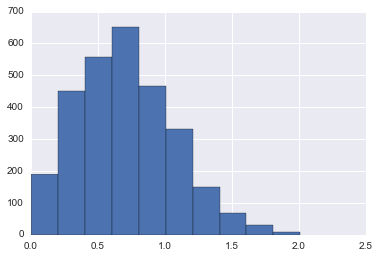

In [189]:
dv = drop_bs('BTC_cbrt_dv_T1', 0.4)

In [195]:
import json
def to_json(df, path):
    a = []
    for i,d in list(df.iterrows()):
        d = d.to_dict()
        d['date'] = str(d['date'])
        a.append(d) 
    with open(path, 'w') as f:
        json.dump(a, f)
        
to_json(dv, '../bitcoin-daily-bars/out-truth-volume.json')

In [205]:
impactfull = cc.ix[itruth.index][itruth]

In [207]:
impactfull.head()

,Actions.Agree.Involved,Actions.Agree.Total,Actions.Comment.Involved,Actions.Comment.NextLoad,Actions.Comment.Total,Actions.Disagree.Involved,Actions.Disagree.Total,Actions.Report.Involved,Actions.Report.Total,Body,Cryptopian.Avatar,Cryptopian.Id,Cryptopian.Name,Edited,Id,Notification,Sticky,ThreadId,Timestamp
31,False,0,False,0,2,False,0,False,0,Any chances of the prices going down??,https://images.cryptocompare.com/87220/1e77675...,87220,shivam.truth,False,68894,False,False,1182,2017-06-22 10:51:44.727
38,False,1,False,3,9,False,0,False,0,how you experts know that btc will reach 3.000...,https://images.cryptocompare.com/88732/9cb05f0...,88732,wdkml82,False,68062,False,False,1182,2017-06-21 19:31:14.737
39,False,2,False,0,6,False,0,False,0,the end of month BTC price will be $3000-$3500,https://images.cryptocompare.com/132924/f69f8a...,132924,smarthamster_72,False,68034,False,False,1182,2017-06-21 18:52:20.900
40,False,0,False,0,3,False,0,False,0,why do people think BTC price can reach $3000 ...,https://images.cryptocompare.com/71410/2e5b5be...,71410,sahiaman,False,67995,False,False,1182,2017-06-21 18:09:30.150
41,False,0,False,0,2,False,0,False,0,Lucky one :(<br/>http://www.cnbc.com/2017/06/2...,https://images.cryptocompare.com/71246/2c9bb51...,71246,ratan.shiv,False,67977,False,False,1182,2017-06-21 17:56:44.017


In [232]:
f = 'Cryptopian.Name'
a = impactfull.groupby(f).size()
b = cc.groupby(f).size()
c = pd.DataFrame(dict(a=a,b=b))
c = c[c.a>1]
c['impact'] = c.a/c.b
c.sort_values('impact', ascending=False)

,a,b,impact
exportech,2.0,2,1.000000
PtahX,3.0,3,1.000000
35514CC0,3.0,3,1.000000
francisco_averos,3.0,3,1.000000
lion80002,2.0,2,1.000000
leedelouche,2.0,2,1.000000
notNowPlease,3.0,3,1.000000
iyer.sumit,2.0,2,1.000000
noimeereyes,2.0,2,1.000000
bitearner,2.0,2,1.000000


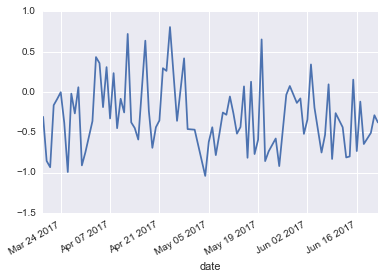

In [240]:
dv.truthscore.plot()

In [ ]:
target_sc